# 地理信息系统设计与开发

In [2]:
import math
import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### dataset

In [3]:
src=r'LC8129043201304_mask.TIF'
dataset=gdal.Open(src)
print(dataset)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000020E19C83120> >


In [4]:
bands=dataset.RasterCount
bands

7

In [5]:
width=dataset.RasterXSize
width

2373

In [6]:
height=dataset.RasterYSize
height

2175

In [7]:
adfGeoTransform = dataset.GetGeoTransform()
adfGeoTransform

(232666.4555650417, 30.0, 0.0, 2800582.2118728245, 0.0, -30.0)

In [8]:
top_left=(adfGeoTransform[0],adfGeoTransform[3])
print("top_left:",top_left)

top_left: (232666.4555650417, 2800582.2118728245)


In [9]:
pixel_size=(adfGeoTransform[1],-adfGeoTransform[5])
print("pixel_size:",pixel_size)

pixel_size: (30.0, 30.0)


In [10]:
img_size=(width,height,bands)
print("img_size:",img_size)

img_size: (2373, 2175, 7)


In [11]:
im_proj = dataset.GetProjection() #地图投影信息
print(im_proj)

PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]


### band

In [12]:
band=dataset.GetRasterBand(1)
band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x0000020E19C7F630> >

In [13]:
gdal.GetDataTypeName(band.DataType)

'Int32'

In [14]:
pixelValueMin=band.GetMinimum()
pixelValueMax=band.GetMaximum()
pixelValueSize=(pixelValueMin,pixelValueMax)
pixelValueSize

(8853.0, 58868.0)

In [15]:
(min,max) = band.ComputeRasterMinMax(True)
print(min,max)

8853.0 58868.0


In [16]:
print(band.GetRasterColorTable())

None


In [17]:
band_array=band.ReadAsArray()

In [18]:
NoData=band.GetNoDataValue()
NoData

-2147483647.0

In [19]:
statistics=band.GetStatistics(True,True)
statistics

[8853.0, 58868.0, 10228.13530233, 975.72630224035]

In [20]:
band=None

#### 显示多波段数据

In [21]:
def myReadBandInfo(dataset,bandNum):
    band=dataset.GetRasterBand(bandNum)
    statis=band.GetStatistics(True,True)
    NoData=band.GetNoDataValue()
    array=band.ReadAsArray()
    mask=array==NoData
    return array,statis[0],statis[1],mask

In [22]:
band4,min4,max4,mask4=myReadBandInfo(dataset,4)
band3,min3,max3,mask3=myReadBandInfo(dataset,3)
band2,min2,max2,mask2=myReadBandInfo(dataset,2)

In [23]:
def myLineStretchEnhance(array,min,max,mask):
    array=np.choose(mask,((array-min)/(max-min),0))*255
    #array=((array-min)/(max-min))*255
    print(array[10,10])
    return array

In [24]:
band4=myLineStretchEnhance(band4,min4,max4,mask4)
band3=myLineStretchEnhance(band3,min3,max3,mask3)
band2=myLineStretchEnhance(band2,min2,max2,mask2)

0.0
0.0
0.0


In [25]:
print(band4.max(),band4.min())

255.0 0.0


In [26]:
def myStackBandDisplay(band4,band3,band2):
    band4=band4.astype(np.uint8)
    band3=band3.astype(np.uint8)
    band2=band2.astype(np.uint8)
    data=np.dstack((band4,band3,band2))
    plt.imshow(data)
    return data

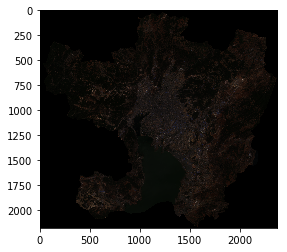

In [27]:
data=myStackBandDisplay(band4,band3,band2)

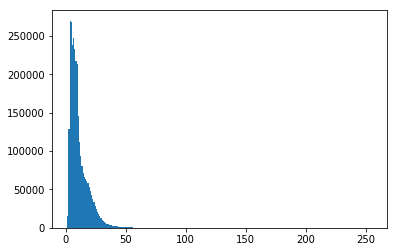

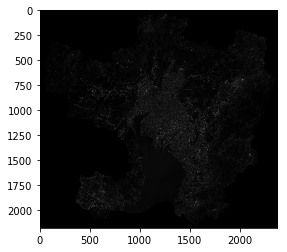

In [28]:
plt.figure()
i=2
ar = data[:,:,i].flatten() 
plt.hist(ar,bins = 256,range=(1,255))

plt.figure()
plt.imshow(data[:,:,i],'gray')

In [29]:
print(data[:,:,0].min(),data[:,:,0].max())

0 255


In [30]:
div=50
for i in range(3):
    mask=data[:,:,i]>div
    data[:,:,i][mask]=div
    print(data[:,:,i].min(),data[:,:,i].max())

0 50
0 50
0 50


In [31]:
def myLineStretchEnhance1(array,min,max):
    #array=np.choose(mask,((array-min)/(max-min),0))*255
    array=((array-min)/(max-min))*255
    print(array[10,10])
    return array

0.0
0.0
0.0


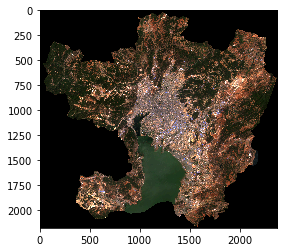

In [32]:
for i in range(3):
    data[:,:,i]=myLineStretchEnhance1(data[:,:,i],data[:,:,i].min(),data[:,:,i].max())
plt.imshow(data)

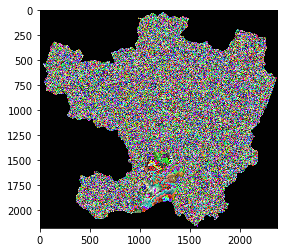

In [33]:
data4=dataset.GetRasterBand(4).ReadAsArray().astype(np.uint8)
data3=dataset.GetRasterBand(3).ReadAsArray().astype(np.uint8)
data2=dataset.GetRasterBand(2).ReadAsArray().astype(np.uint8)
data=np.dstack((data4,data3,data2))
plt.imshow(data)

In [34]:
dataset_classify=gdal.Open('isoclasstest.tif')
print(dataset_classify.RasterCount)
band_classify=dataset_classify.GetRasterBand(1)
print(gdal.GetDataTypeName(band_classify.DataType))
classify_array=band_classify.ReadAsArray()
plt.imshow(classify_array,cmap="RdYlGn")
color=[[0,0,0],[255,0,0],[0,255,0],[0,0,255]]


AttributeError: 'NoneType' object has no attribute 'RasterCount'

In [ ]:
#dataset=gdal.Open('LC8129043201304_mask.tif')
band4=dataset.GetRasterBand(4).ReadAsArray().astype(float)
band5=dataset.GetRasterBand(5).ReadAsArray().astype(float)
ndvi=(band5-band4)/(band5+band4)
plt.figure()
plt.title('NDVI')
plt.imshow(ndvi,cmap='gray')

In [ ]:
def myCountDis(pixel,center):

    return abs(pixel-center)

In [ ]:
def myKMeansClassify(ndvi,classnum,iterationnum):
    center=[-0.08,0,0.05,0.1,0.2,0.3,0.4,0.5]
    height,width=ndvi.shape
    myclassmap=np.zeros((height,width),np.int)
    #for i in range(classnum):
        #center.append(np.random.uniform(0.05,0.7))
    print('center:',center)

    for n in range(iterationnum):
        for i in range(height):
            for j in range(width):
                dis=[]
                for k in range(classnum):
                    dist=myCountDis(ndvi[i,j],center[k])
                    dis.append(dist)

                disarray=np.array(dis)
                dismin=disarray.min()

                myclassmap[i,j]=dis.index(dismin)

            print("分类迭代进度:{0}%,Iterationnum:{1}".format(round((i + 1) * 100 / height),n), end="\r")

        center=[]
        for k in range(classnum):
            mask=np.equal(myclassmap,k)
            center.append(np.mean(ndvi[mask]))
        print("mean{0}:{1}".format(k,center), end="\r")


    return myclassmap

In [ ]:
myclass=myKMeansClassify(ndvi,6,2)

In [ ]:
plt.imshow(myclass,cmap='RdYlGn')

In [ ]:
def distEclud(vecA,vecB):

    return math.sqrt(np.power(vecA - vecB, 2))
    #return np.abs(vecA-vecB)

def myKmeansClassify(ndvi,classnum,Iterationnum):
    height,width=ndvi.shape
    myclass=np.zeros((height,width),np.int)
    center=[]
    for i in range(classnum):
        center.append(np.random.uniform(0.05,0.7))
    print("center:",center)

    for n in range(Iterationnum):
        for i in range(height):
            for j in range(width):
                dis=[]
                for k in range(classnum):#每个像元到各个类中心的距离
                    dist=distEclud(ndvi[i,j], center[k])
                    if(dist != None):
                        dis.append(distEclud(ndvi[i,j], center[k])


                disarray=np.array(dis)
                dismin=disarray.min()

                myclass[i,j]=dis.index(dismin)


            print("分类迭代进度:{0}%,Iterationnum:{1}".format(round((i + 1) * 100 / height),n), end="\r")

        center=[] #重新确定类中心
        for k in range(classnum):
            mask=np.equal(myclass,k)
            myclassmean=np.mean(ndvi[mask])
            center.append(myclassmean)
            print("mean{0}:{1}".format(k,myclassmean), end="\r")

        plt.subplot(2,3,n+1)
        plt.imshow(myclass,cmap="RdYlGn")

    return myclass

In [ ]:
myclass=myKmeansClassify(ndvi,6,2)

In [ ]:
plt.imshow(myclass,cmap='RdYlGn')

In [ ]:
dataset=None

In [ ]:
center=[-0.08,0,0.05,0.1,0.2,0.3,0.4,0.5]
min(center)
ct=np.array(center)
print(ct.min())
center.index(0.05)